<a href="https://colab.research.google.com/github/Anubhav2017/Genomics_notebooks/blob/main/approach_kmer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D,Reshape, LSTM, Dropout, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.utils import shuffle

bases={'A':np.array([0,0,0,1]), 'C':np.array([0,0,1,0]), 'G':np.array([0,1,0,0]), 'T':np.array([1,0,0,0])}

def Kmers_funct(seq, size):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

def one_hot_encode_2(y,num_classes):
    y_encoded=[]
    for value in y:
	    letter = [0 for _ in range(num_classes)]
	    letter[value] = 1
	    y_encoded.append(letter)
    return np.array(y_encoded,dtype=np.float16)



In [ ]:
import random

def selectref(el,pa,pc,pg,pt):

  dicref={'U':['T'],
  'R':['A','G'],
  'Y':['C','T'],
  'S':['G','C'],
  'W':['A','T'],
  'K':['G','T'],
  'M':['A','C'],
  'B':['C','G','T'],
  'D':['A','G','T'],
  'H':['A','C','T'],
  'V':['A','C','G'],
  'N':['A','T','G','C'],
  }

  dicprobs={'U':[1],
  'R':[pa/(pa+pg),pg/(pa+pg)],
  'Y':[pc/(pc+pt),pt/(pc+pt)],
  'S':[pg/(pc+pg),pc/(pc+pg)],
  'W':[pa/(pa+pt),pt/(pa+pt)],
  'K':[pg/(pt+pg),pt/(pt+pg)],
  'M':[pa/(pa+pc),pc/(pa+pc)],
  'B':[pc/(pc+pg+pt),pg/(pc+pg+pt),pt/(pc+pg+pt)],
  'D':[pa/(pa+pg+pt),pg/(pa+pg+pt),pt/(pa+pg+pt)],
  'H':[pa/(pc+pa+pt),pc/(pc+pa+pt),pt/(pc+pa+pt)],
  'V':[pa/(pc+pg+pa),pc/(pc+pg+pa),pg/(pc+pg+pa)],
  'N':[pa/(pc+pg+pa+pt),pt/(pc+pg+pa+pt),pg/(pc+pg+pa+pt),pc/(pc+pg+pa+pt)]}

  # print(dicprobs[el])
  
  return np.random.choice(dicref[el],p=dicprobs[el])
  # return np.random.choice(dicref[el],p=dicprobs[el])





In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install BioPython

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

unique_elems=dict()

all_sequences=[]

for sequence in SeqIO.parse('/content/drive/My Drive/ncbi_16s_18s_merged.fasta', "fasta"):
    unique_elems[sequence.description.split()[1]]=0
    seq=""

    base_count=dict()
    base_count['A']=0
    base_count['C']=0
    base_count['G']=0
    base_count['T']=0
    base_count['others']=0

    for el in sequence.seq:
      if el not in base_count.keys():

        base_count['others']+=1
      else:
        base_count[el]+=1
    
    na=base_count['A']
    nc=base_count['C']
    ng=base_count['G']
    nt=base_count['T']

    pa=float(na/(na+nc+ng+nt))
    pc=float(nc/(na+nc+ng+nt))
    pg=float(ng/(na+nc+ng+nt))
    pt=float(nt/(na+nc+ng+nt))

    
    for el in sequence.seq:
      if el not in base_count.keys():

        seq += (selectref(el,pa,pc,pg,pt))
      else:
        seq+=el
    
    words = Kmers_funct(seq, size=6)
    joined_sentence = ' '.join(words)
    all_sequences.append(joined_sentence)

X=cv.fit_transform(all_sequences).toarray()

print(X.shape)



    
    

    

(24855, 4096)


In [ ]:
i=0
x_data=[]
y_data=[]
for el in unique_elems.keys():
    unique_elems[el]=i
    i+=1

i=0
for sequence in SeqIO.parse('/content/drive/My Drive/ncbi_16s_18s_merged.fasta', "fasta"):
    x_data.append(X[i])
    y_data.append(unique_elems[sequence.description.split()[1]])
    i+=1

lm=len(unique_elems)

class_count=dict()

for i in range(lm):
  class_count[i]=0

for el in y_data:
  class_count[el]+=1



Text(0.5, 1.0, 'Number of samples corresponding to various genus')

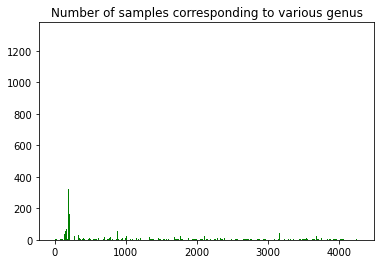

In [ ]:
import matplotlib.pyplot as plt

plt.bar(class_count.keys(), class_count.values(), color='g')
plt.title("Number of samples corresponding to various genus")

In [ ]:
dominant_classes=([idx for idx, element in enumerate(class_count.values()) if element>50])


indices_to_remove=[]

for el in dominant_classes:
  # print(list(np.where(np.array(y_data) == el))[0])
  indices_to_remove+=random.choices(list(np.where(np.array(y_data) == el)[0]),k=class_count[el]-50)
  



In [ ]:
x_data_new=[]
y_data_new=[]

for i in range(len(x_data)):
  if i not in indices_to_remove:
    x_data_new.append(x_data[i])
    y_data_new.append(y_data[i])



In [ ]:

def release_list(a):
   del a[:]
   del a

release_list(x_data)
release_list(y_data)

Text(0.5, 1.0, 'Number of samples corresponding to various genus')

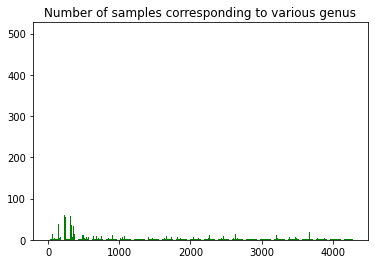

In [ ]:
class_count=dict()

for i in range(lm):
  class_count[i]=0
for el in y_data_new:
  class_count[el]+=1


plt.bar(class_count.keys(), class_count.values(), color='g')
plt.title("Number of samples corresponding to various genus")

In [ ]:
desired_count=dict()

for i in range(lm):
  if class_count[i]<10:
    desired_count[i]=10
  else:
    desired_count[i]=class_count[i]


In [ ]:
# from imblearn.over_sampling import SMOTE, RandomOverSampler

# oversample = RandomOverSampler(sampling_strategy=desired_count)
# x,y=oversample.fit_resample(x_data_new, y_data_new)

Text(0.5, 1.0, 'Number of samples corresponding to various genus')

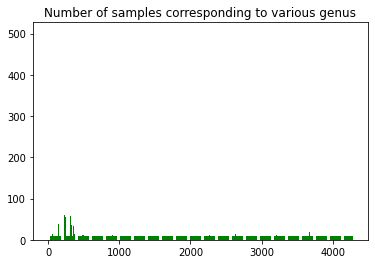

In [ ]:

plt.bar(desired_count.keys(), desired_count.values(), color='g')
plt.title("Number of samples corresponding to various genus")

In [ ]:
x_data=x_data_new.copy()
y_data=y_data_new.copy()

In [ ]:

# x_train=[]
# y_train=[]

# rare_items=[]

# for item in class_count.keys():
#   if class_count[item] < 2:
#     rare_items.append(item)

# i=0
# for el in y_data_new:
#   if el in rare_items:
#     x_train.append(x_data_new[i])
#     y_train.append(el)

#   i+=1


x_data,y_data=shuffle(x_data,y_data)

x_train=x_data[:int(len(x_data)*0.8)]
y_train=y_data[:int(len(y_data)*0.8)]


x_test=x_data[int(len(x_data)*0.8):]
y_test=y_data[int(len(y_data)*0.8):]

print(len(x_train))

y_train=one_hot_encode_2(y_train,len(unique_elems))
y_test=one_hot_encode_2(y_test,len(unique_elems))

x_train=np.array(x_train,dtype=np.float32)
x_train=np.reshape(x_train,(-1,4096,1))

x_test=np.array(x_test,dtype=np.float32)
x_test=np.reshape(x_test,(-1,4096,1))

16784


In [ ]:
import os
checkpoint_path = "/content/drive/My Drive/training_genomics_kmer/{epoch:03d}/cp-{epoch:04d}"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
model=Sequential()
model.add((Conv1D(filters=6, kernel_size=6, activation='relu')))
model.add((Conv1D(filters=3, kernel_size=6, activation='relu')))
model.add(Flatten())
model.add(Dense(units=1024,activation='relu'))
model.add(Dense(units=lm, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights("/content/drive/My Drive/training_genomics_kmer/010/cp-0010")
early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')

history = model.fit(x_train[0:1], y_train[0:1], epochs=1, verbose=1)
model.summary()
# history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data= (x_test,y_test),callbacks=[cp_callback])


1/1 [==============================] - 14s 14s/step - loss: 0.0013 - accuracy: 1.0000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4091, 6)           42        
                                                                 
 conv1d_1 (Conv1D)           (None, 4086, 3)           111       
                                                                 
 flatten (Flatten)           (None, 12258)             0         
                                                                 
 dense (Dense)               (None, 1024)              12553216  
                                                                 
 dense_1 (Dense)             (None, 4283)              4390075   
                                                                 
Total params: 16,943,444
Trainable params: 16,943,444
Non-trainable params: 0
________________________

In [37]:
from sklearn import metrics

preds_test=model.predict(x_test)

y_preds_labels=[np.argmax(el) for el in preds_test]
y_test_labels=[np.argmax(el) for el in y_test]

print(metrics.confusion_matrix(y_test_labels, y_preds_labels))

print(metrics.classification_report(y_test_labels, y_preds_labels, digits=3))


[[2 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      1.000     1.000     1.000         4
           2      1.000     1.000     1.000         6
           3      1.000     1.000     1.000         5
           4      1.000     1.000     1.000         1
           5      1.000     1.000     1.000         1
           6      1.000     1.000     1.000         2
           7      1.000     1.000     1.000         3
           8      1.000     1.000     1.000         2
          10      1.000     1.000     1.000         1
          12      1.000     1.000     1.000         2
          14      1.000     1.000     1.000         4
          15      1.000     1.000     1.000         3
          16      1.000     1.000     1.000         1
          17      1.000     1.000     1.000         1
          20   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [43]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

fpr = {}
tpr = {}
thresh ={}
roc_auc={}
n_class = lm
# y_true=np.array(y_true)
# preds_training_data=model.predict(x_train)
# print(preds[0:3])
# print(y_test[0:3])

for i in range(n_class):
  # print(y_train[:,i])

  if len(np.unique(y_test[:,i]))==2:
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test[:,i], preds_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [39]:
reverse_dic=dict()

for el in unique_elems.keys():
  reverse_dic[unique_elems[el]]=el

In [40]:
for i in range(len(y_preds_labels)):
  if y_preds_labels[i] != y_test_labels[i]:
    print("True label= "+str(reverse_dic[y_test_labels[i]]))
    print("Predicted label= "+str(reverse_dic[y_preds_labels[i]]))


True label= Halomonas
Predicted label= Cobetia
True label= Halomonas
Predicted label= Cobetia
True label= Halomonas
Predicted label= Cobetia
True label= Halomonas
Predicted label= Cobetia
True label= Camarosporidiella
Predicted label= Neophaeosphaeria
True label= Salinicola
Predicted label= Cobetia
True label= Mycobacterium
Predicted label= Mycolicibacterium
True label= Streptomyces
Predicted label= Streptoverticillium
True label= Lecanicillium
Predicted label= Akanthomyces
True label= Halomonas
Predicted label= Cobetia
True label= Cryptocoryneum
Predicted label= Pseudocryptoclypeus
True label= Salinicola
Predicted label= Cobetia
True label= Middelhovenomyces
Predicted label= Candida
True label= Pararheinheimera
Predicted label= Rheinheimera
True label= Halomonas
Predicted label= Cobetia
True label= Halomonas
Predicted label= Cobetia
True label= Murichromolaenicola
Predicted label= Galiicola
True label= [Candida]
Predicted label= Metschnikowia
True label= Lophiotrema
Predicted label= C

In [50]:
print(min(roc_auc.values()))

0.9826380580149424


In [ ]:
release_list(y_data)

In [ ]:
import random
a=[1,2,3,4]
b=random.sample(a,2)
print(a)
print(b)